In [118]:
import os
os.chdir("/Users/aliahmadi/Documents/Projects/RNA Secondary Structure Prediction")

## Array Of Files

In [119]:
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.linalg import expm
from grammar.pcnf import PCNF
from Bio import Phylo, SeqIO
from random import choice 
from copy import deepcopy
from io import StringIO
import networkx as nx
from math import log 
import numpy as np
import shutil

In [120]:
trees = defaultdict(lambda: Phylo.read(StringIO("();"), "newick"))
sequences = defaultdict(lambda: defaultdict(str))
structures = defaultdict(str)

predicted_struct = {}

In [121]:
def create_tree(input_sequences, filename = "./outputs/tree.nwk", draw=True):
  names = list(input_sequences.keys())
  sequences = list(input_sequences.values())
  
  if len(names) <= 2:
    return None
  
  os.mkdir("./tmp")

  if len(names) > 2:
    phylip_file = "./tmp/sequences.phylip"
    with open(phylip_file, "w") as f:
      f.write(f"{len(sequences)} {len(sequences[0])}\n\n")
      for i, seq in enumerate(sequences):
        f.write(f"{names[i]}\t{seq}\n") 
    
    !./phyml -i tmp/sequences.phylip -m GTR
    
    output_tree = Phylo.read(phylip_file + "_phyml_tree.txt", 'newick')
    output_tree.root_at_midpoint()

  for index, clade in enumerate(output_tree.find_clades()):
    if not clade.name:
      clade.name = str(index)
  
  shutil.rmtree("./tmp")
  Phylo.write(output_tree, filename, "newick")
  
  output_tree.root.color = "blue"
  Phylo.draw(output_tree)
  
  return output_tree

In [122]:
input_sequences = {
    "Seq1": "GGGGCGAGCUGCAGCCCCAGUGAAUCAAAUGCAGC",
    "Seq2": "GGGGCUAGCUGCAGCCCCAGUGAACCAAGUGCAGC",
    "Seq3": "GGGGCGAGCUGCAGCCCCAGUGAAUCAAGUGCAGC",
    "Seq4": "GGGGCGAGCUGCAGCCCCAGUAAACCAAGUGCAGC",
    "Seq5": "GGGGCGAGCUGCAGCCCCGGUAAAUCAAGUGCAGC",
}







                                 ..........................                                      
 ooooooooooooooooooooooooooooo        CURRENT SETTINGS        ooooooooooooooooooooooooooooooooooo
                                 ..........................                                      

                . Sequence filename:				 sequences.phylip
                . Data type:					 dna
                . Alphabet size:				 4
                . Sequence format:				 interleaved
                . Number of data sets:				 1
                . Nb of bootstrapped data sets:			 0
                . Compute approximate likelihood ratio test:	 yes (SH-like branch supports)
                . Model name:					 GTR
                . Proportion of invariable sites:		 0.000000
                . Number of subst. rate categs:			 4
                . Gamma distribution parameter:			 estimated
                . 'Middle' of each rate class:			 mean
                . Nucleotide equilibrium frequencies:	

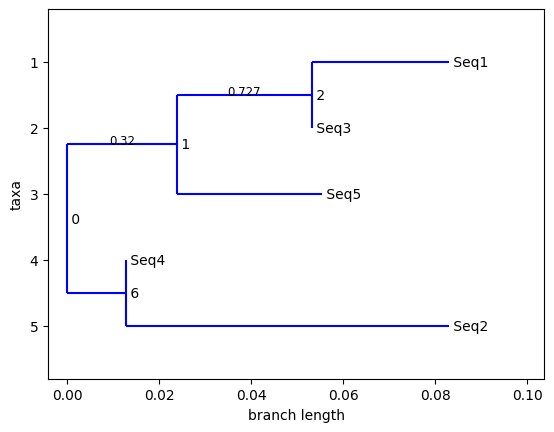

In [123]:
estimated_tree = create_tree(input_sequences)

In [124]:
leaf_distances = {}
for leaf in estimated_tree.get_terminals():
    distance = estimated_tree.distance(estimated_tree.root, leaf)
    leaf_distances[leaf.name] = distance

# Print distances
for leaf, distance in leaf_distances.items():
    print(f"Leaf {leaf}: Distance from root = {distance:.4f}")

Leaf Seq1: Distance from root = 0.0829
Leaf Seq3: Distance from root = 0.0533
Leaf Seq5: Distance from root = 0.0554
Leaf Seq4: Distance from root = 0.0128
Leaf Seq2: Distance from root = 0.0829


In [125]:
iupac_nucleotides = {
    'A':["A"],
    'C':["C"],
    'G':["G"],
    'U':["U"], 
    'R':["A", "G"], 
    'Y':["C", "U"],
    'S':["G", "C"],
    'W':["A", "U"],
    'K':["G", "U"],
    'M':["A", "C"],
    'B':["C", "G", "U"],
    'D':["A", "G", "U"],
    'H':["A", "C", "U"],
    'V':["A", "C", "G"],
    'N':["A", "C", "G", "U"],
    '-': ["-"]
}

In [126]:
def is_valid_str(input_string, valid_characters = ['A','C', 'G', 'U']):
    for char in input_string:
        if char not in valid_characters:
            return False
    return True

In [127]:
def get_pair_start(pair_end):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return [val for val in pairing_chars if val[1] == pair_end][0][0]

In [128]:
def is_pair_start(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[0] for p in pairing_chars]

In [129]:
def is_pair_end(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[1] for p in pairing_chars]

In [130]:
def calc_frequencies (sequences, structures):
    single_nucleotides = defaultdict(int)
    paired_nucleotides = defaultdict(int)
    
    total_singles = 0
    total_paireds = 0
    
    # Stack of unpaired nucleotides (structure symbol, nocleotide)
    unpaired_nucleotides = []
    for dataset_name, dataset_values in sequences.items():
        sequences_weight = dataset_values["_weight"]
        dataset_sequences = [v for k, v in dataset_values.items() if k != "_weight"]
        dataset_structure = structures[dataset_name]
        for sequence in dataset_sequences:
            for index, nucleotide in enumerate(sequence): 
                structure_symbol = dataset_structure[index]
                # Having a charecter [ '(', '[', '{', '<' ]
                if is_pair_start(structure_symbol):
                    unpaired_nucleotides.append((structure_symbol, iupac_nucleotides[nucleotide]))
                # Having a charecter [ ')', ']', '}', '>' ]
                elif is_pair_end(structure_symbol):
                    unpaired_nucleotide = unpaired_nucleotides.pop()
                    if unpaired_nucleotide[0] == get_pair_start(structure_symbol):
                        targets = [f"{nucl1}{nucl2}" 
                            for nucl1 in unpaired_nucleotide[1] 
                            for nucl2 in iupac_nucleotides[nucleotide]
                        ]
                        for target in targets:
                            if is_valid_str(target):
                                # print(len(targets))
                                paired_nucleotides[target] += sequences_weight / len(targets)
                                paired_nucleotides[target[::-1]] += sequences_weight / len(targets)
                                
                                total_paireds += sequences_weight / len(targets)
                    else:
                        raise ValueError('Invalid pattern in structure')
                # Having a non-pairing charecter
                else:
                    targets = iupac_nucleotides[nucleotide]
                    for target in targets:
                        if is_valid_str(nucleotide):
                            # print(len(targets))
                            single_nucleotides[target] += sequences_weight / len(targets)
                            
                            total_singles += sequences_weight / len(targets)

    total = total_singles + (total_paireds * 2)
                
    for key, value in single_nucleotides.items():
        single_nucleotides[key] = value / total_singles
    for key, value in paired_nucleotides.items():
        paired_nucleotides[key] = value / (total_paireds * 2)
        
    return (
        single_nucleotides,
        paired_nucleotides,
        total_singles / total,
        (total_paireds * 2) / total
    )

In [131]:
def check_simularity(seq1:str, seq2:str):
    simularity = 0
    if len(seq1) == len(seq2):
        for i in range(len(seq1)):
            if seq1[i] == seq2[i]:
                simularity += 1
        return simularity / len(seq1) >= .85

In [132]:
def calc_rate_values(
    trees,
    sequences: defaultdict, 
    structures, 
    single_frequencies, 
    paired_frequencies, 
    singles_prob, 
    paireds_prob
):
    unpaired_nucleotides = []
    
    single_mutation_count = defaultdict(float)
    paired_mutation_count = defaultdict(float)
    k_value = 0
    
    for dataset_name, dataset_values in sequences.items():
        sequences_weight = dataset_values["_weight"]
        dataset_sequences = [(k, v) for k, v in dataset_values.items() if k != "_weight"]
        dataset_structure = structures[dataset_name]
        
        for i in range(len(dataset_sequences)):
            temp_single_mutation_count = defaultdict(int)
            temp_paired_mutation_count = defaultdict(int)
            k_temp = 0
            
            same_first_sequence_count = 0
            
            for j in range(len(dataset_sequences)):
                columns_count = 0
                
                first_name = dataset_sequences[i][0]
                second_name = dataset_sequences[j][0]
                first_sequence = dataset_sequences[i][1]
                second_sequence = dataset_sequences[j][1]
                # The pair should contain diffrent 
                # sequence with at least %85 simularity.
                if i != j and check_simularity(first_sequence, second_sequence):
                    same_first_sequence_count += 1
                    for k in range(len(first_sequence)): 
                        structure_symbol = dataset_structure[k]
                        # Having a charecter [ '(', '[', '{', '<' ]
                        if is_pair_start(structure_symbol):
                            unpaired_nucleotides.append((
                                structure_symbol, 
                                iupac_nucleotides[first_sequence[k]],
                                iupac_nucleotides[second_sequence[k]]
                            ))
                        # Having a charecter [ ')', ']', '}', '>' ]
                        elif is_pair_end(structure_symbol):
                            unpaired_nucleotide = unpaired_nucleotides.pop()
                            
                            first_side_targets = [f"{nucl1}{nucl2}" 
                                for nucl1 in unpaired_nucleotide[1] 
                                for nucl2 in iupac_nucleotides[first_sequence[k]]
                            ]
                            second_side_targets = [f"{nucl1}{nucl2}" 
                                for nucl1 in unpaired_nucleotide[2] 
                                for nucl2 in iupac_nucleotides[second_sequence[k]]
                            ]
                            
                            if unpaired_nucleotide[0] == get_pair_start(structure_symbol):
                                for first_side in first_side_targets:
                                    for second_side in second_side_targets:
                                        if (is_valid_str(first_side) 
                                        and is_valid_str(second_side)):
                                            columns_count += (2 * sequences_weight) / (len(first_side_targets) * len(second_side_targets))
                                            
                                            if first_side != second_side:
                                                temp_paired_mutation_count[
                                                    (first_side, second_side)
                                                ] += sequences_weight / (len(first_side_targets) * len(second_side_targets))
                                                temp_paired_mutation_count[
                                                    (first_side[::-1], second_side[::-1])
                                                ] += sequences_weight / (len(first_side_targets) * len(second_side_targets))
                            else:
                                raise ValueError('Invalid pattern in structure')    
                        # Having a non-pairing charecter
                        else:
                            first_side_targets = iupac_nucleotides[first_sequence[k]]
                            second_side_targets = iupac_nucleotides[second_sequence[k]]
                            
                            for first_side in first_side_targets:
                                for second_side in second_side_targets:
                                    if (is_valid_str(first_side) 
                                    and is_valid_str(second_side)):
                                        columns_count += sequences_weight / (len(first_side_targets) * len(second_side_targets))
                                        if first_side != second_side:
                                            temp_single_mutation_count[(
                                                first_side, 
                                                second_side,
                                            )] += sequences_weight / (len(first_side_targets) * len(second_side_targets))
                    
                    k_temp += (trees[dataset_name].distance(
                        first_name, 
                        second_name
                    ) * columns_count)
                    
            
            if same_first_sequence_count > 0:
                k_value += (k_temp / same_first_sequence_count)
                
                for key in temp_single_mutation_count:
                    single_mutation_count[key] += (temp_single_mutation_count[key] 
                                                / same_first_sequence_count)
                for key in temp_paired_mutation_count:
                    paired_mutation_count[key] += (temp_paired_mutation_count[key] 
                                                / same_first_sequence_count)
                
    single_chars = ["A", "C", "G", "U"]
    paired_chars = [c1 + c2 for c1 in single_chars for c2 in single_chars]
    
    single_rate_values = defaultdict(float)
    paired_rate_values = defaultdict(float)
            
    for i in single_chars:
        single_rate_values[(i,i)] = 0
        for j in single_chars:
            if i != j:
                single_rate_values[(i,j)] = (single_mutation_count[(i,j)] 
                                             / (singles_prob * single_frequencies[i] * k_value))
                single_rate_values[(i,i)] = single_rate_values[(i,i)] - single_rate_values[(i,j)]

    for i in paired_chars:
        paired_rate_values[(i,i)] = 0
        for j in paired_chars:
            if i != j:
                paired_rate_values[(i,j)] = ((paired_mutation_count[(i,j)] * 2)
                                             / (paireds_prob * paired_frequencies[i] * k_value))
                paired_rate_values[(i,i)] = paired_rate_values[(i,i)] - paired_rate_values[(i,j)]
    
    return single_rate_values, paired_rate_values  

In [133]:
def get_mutation_probablities(mutation_rate_values, time, order_array = ["A", "C", "G", "U"]):
    mutation_rate_matrix = np.zeros((len(order_array), len(order_array)), np.float64)
    
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            mutation_rate_matrix[i_index,j_index] = mutation_rate_values[(i_value, j_value)]
    
    probability_rate_matrix = expm(mutation_rate_matrix * time)
    
    probability_rate_values = defaultdict(float)
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            probability_rate_values[(i_value, j_value)] = probability_rate_matrix[i_index,j_index]
    
    return probability_rate_values

In [134]:
def pattern_successor(pattern):
    order = ["A", "C", "G", "U"]
    last_filled = len(pattern) - 1
    gap_shifted = False

    for i in range(len(pattern)):
        if pattern[i] != "-":
            if pattern[i] == order[-1]:
                pattern[i] = order[0]
            else:
                index = order.index(pattern[i])
                pattern[i] = order[index + 1]
                return pattern
    
    indices = [i for i, x in enumerate(pattern) if x == '-']
    
    for index in indices[::-1]:
        if index == last_filled and pattern[index] == "-":
            last_filled -= 1
            pattern[index] = order[0]
            continue
        elif index != last_filled and pattern[index] == "-":
            pattern[index] = order[0]
            for shifte in range(len(pattern) - last_filled):
                pattern[(index + shifte + 1)] = "-"
            gap_shifted = True
            break
    
    if not gap_shifted:
        if (len(pattern) - last_filled) == (len(pattern) + 1):
            return []
        else:
            for index in range(len(pattern) - last_filled):
                pattern[index] = "-"
    
    return pattern

In [135]:
def add_gap_probablities(columns_probability, height, paired = False):
    pattern = (["U"] * height * 2) if paired else (["U"] * height)
    
    while pattern_successor(pattern) != []:
        index = pattern.index("-")
        order = ["A", "C", "G", "U"]
        probability = 0
        for n in order:
            pattern[index] = n
            if paired:
                    probability += columns_probability[tuple([
                        pattern[i] + pattern[i+1] for i in range(0, len(pattern), 2)
                    ])]
            else:
                probability += columns_probability[tuple(pattern)]
        pattern[index] = "-"
        
        if paired:
            columns_probability[tuple([
                pattern[i] + pattern[i+1] for i in range(0, len(pattern), 2)
            ])] = probability
            
        else:
            columns_probability[tuple(pattern)] = probability
    columns_probability

In [136]:
def post_order_traversal(tree, current_node, possible_values, rate_values, leaf_order = []): 
    current_columns_probability = defaultdict(lambda: defaultdict(float))
    
    for child in current_node.clades:
        # going to add a branch with a single nucleotide 
        if child.is_terminal():
            leaf_order.append(child.name)
            
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, possible_values)
            
            # have filled with some branch in last iteration
            if current_columns_probability:
                perv_columns_probability = deepcopy(current_columns_probability)
                current_columns_probability.clear()
                
                for left_column in perv_columns_probability:
                    for root in perv_columns_probability[left_column]:
                        for child_value in possible_values:
                            current_columns_probability[left_column + (child_value ,)][root] = (
                                mutation_probablities[(root, child_value)] * 
                                perv_columns_probability[left_column][root]
                            )
                perv_columns_probability.clear()
            
            # haven't filled with any branch in last iteration
            else:
                for mutation in mutation_probablities:
                    current_columns_probability[(mutation[1] ,)][mutation[0]] = mutation_probablities[mutation]
        # going to add a branch with a more than one nucleotide 
        else:    
            inner_columns_probability, _ = post_order_traversal(tree, child, possible_values, rate_values, leaf_order)
            
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, possible_values)
            
            # have filled with some branch in last iteration
            if current_columns_probability:
                perv_columns_probability = deepcopy(current_columns_probability)
                current_columns_probability.clear()
                
                for left_column in perv_columns_probability:
                    for root in perv_columns_probability[left_column]:
                        for right_column in inner_columns_probability:
                            current_columns_probability[left_column + right_column][root] = sum(
                                (
                                    mutation_probablities[(root, inner_root)] * 
                                    inner_columns_probability[right_column][inner_root] * 
                                    perv_columns_probability[left_column][root]
                                ) for inner_root in inner_columns_probability[right_column])
                
                perv_columns_probability.clear()

            # haven't filled with some branch in last iteration
            else:
                for root_value in possible_values:
                    for column in inner_columns_probability:
                        current_columns_probability[column][root_value] = sum(
                            (
                                mutation_probablities[(root_value, inner_root)] * 
                                inner_columns_probability[column][inner_root]
                            ) for inner_root in inner_columns_probability[column]
                        )
                    
    return current_columns_probability, leaf_order

In [137]:
def get_columns_probability(
    tree,  
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values,
):
    single_possible_values = ['A', 'C', 'G', 'U']
    paired_possible_values = [c1 + c2 for c1 in single_possible_values for c2 in single_possible_values]
    
    __single_columns_probability, leaf_order = post_order_traversal(
        tree, 
        tree.root, 
        single_possible_values, 
        single_rate_values,
        []
    )
    single_columns_probability = defaultdict(float)
    for column in __single_columns_probability:
        single_columns_probability[column] = sum(
            __single_columns_probability[column][root] 
            * single_frequencies[root] for root in single_possible_values
        )
    __single_columns_probability.clear()
    
    __paired_columns_probability, _ = post_order_traversal(
        tree, 
        tree.root, 
        paired_possible_values, 
        paired_rate_values, 
        []
    )
    paired_columns_probability = defaultdict(float)
    for column in __paired_columns_probability:
        paired_columns_probability[column] = sum(
            __paired_columns_probability[column][root] 
            * paired_frequencies[root] for root in paired_possible_values
        )
    __paired_columns_probability.clear()
    
    add_gap_probablities(single_columns_probability, tree.count_terminals(), paired=False)
    add_gap_probablities(paired_columns_probability, tree.count_terminals(), paired=True)
    
    return single_columns_probability, paired_columns_probability, leaf_order

In [138]:
def read_structure(filename: str, dataset_name):
    with open(filename) as file:
        structures[dataset_name] = file.readline().strip()

In [139]:
def clade_names_fix(tree):
    for index, clade in enumerate(tree.find_clades()):
        if not clade.name:
            clade.name = str(index)

def read_tree(filename: str):
    Tree = Phylo.read(filename, 'newick')
    clade_names_fix(Tree)
    return Tree

def open_tree(filename: str, dataset_name):
    Tree = Phylo.read(filename, 'newick')
    clade_names_fix(Tree)
    
    trees[dataset_name] = Tree

In [140]:
def read_sequences (filename: str, dataset_name):
    dataset = defaultdict(str)
    
    with open(filename) as file:
        records = SeqIO.parse(file, "phylip-relaxed")
        count = 0
        
        for record in records:
            dataset[record.id] = record.seq
            count += 1
           
        dataset["_weight"] = 1000 / count   
        
    sequences[dataset_name] = dataset

In [141]:
open_tree("./primaries/trees/RF00001.nwk", "RF00001")
open_tree("./primaries/trees/RF00005.nwk", "RF00005")
# open_tree("./primaries/trees/RF00162.nwk", "RF00162")
# open_tree("./primaries/trees/RF01704.nwk", "RF01704")
# open_tree("./primaries/trees/RF01734.nwk", "RF01734")
# open_tree("./primaries/trees/RF01739.nwk", "RF01739")
# open_tree("./primaries/trees/RF02035.nwk", "RF02035")
open_tree("./primaries/trees/RF02957.nwk", "RF02957")
open_tree("./primaries/trees/RF03000.nwk", "RF03000")
# open_tree("./primaries/trees/RF03054.nwk", "RF03054")
# open_tree("./primaries/trees/RF03135.nwk", "RF03135")

read_sequences("./primaries/phylips/RF00001.phylip", "RF00001")
read_sequences("./primaries/phylips/RF00005.phylip", "RF00005")
# read_sequences("./primaries/phylips/RF00162.phylip", "RF00162")
# read_sequences("./primaries/phylips/RF01704.phylip", "RF01704")
# read_sequences("./primaries/phylips/RF01734.phylip", "RF01734")
# read_sequences("./primaries/phylips/RF01739.phylip", "RF01739")
# read_sequences("./primaries/phylips/RF02035.phylip", "RF02035")
read_sequences("./primaries/phylips/RF02957.phylip", "RF02957")
read_sequences("./primaries/phylips/RF03000.phylip", "RF03000")
# read_sequences("./primaries/phylips/RF03054.phylip", "RF03054")
# read_sequences("./primaries/phylips/RF03135.phylip", "RF03135")

read_structure("./primaries/structures/RF00001.structure", "RF00001")
read_structure("./primaries/structures/RF00005.structure", "RF00005")
# read_structure("./primaries/structures/RF00162.structure", "RF00162")
# read_structure("./primaries/structures/RF01704.structure", "RF01704")
# read_structure("./primaries/structures/RF01734.structure", "RF01734")
# read_structure("./primaries/structures/RF01739.structure", "RF01739")
# read_structure("./primaries/structures/RF02035.structure", "RF02035")
read_structure("./primaries/structures/RF02957.structure", "RF02957")
read_structure("./primaries/structures/RF03000.structure", "RF03000")
# read_structure("./primaries/structures/RF03054.structure", "RF03054")
# read_structure("./primaries/structures/RF03135.structure", "RF03135")

In [142]:
def simplify_struct(structures, filename="./primaries/structures"):
    pairing_chars = ["<", ">", "(", ")", "[", "]", "{", "}"]
    simplified = ""
    for _, structure in structures.items():
        for i in range(len(structure)):
            if structure[i] in pairing_chars:
                simplified += "d "
            else:
                simplified += "s "
        simplified += "\n"
    
    simplified = simplified.rstrip('\n')
    
    if filename != "":        
        with open(f"{filename}.train", "w+") as file:
            file.write(simplified)

In [143]:
simplify_struct(structures, filename="./primaries/structures")

In [144]:
# calc_frequencies(sequences, structures)
(single_frequencies, 
 paired_frequencies, 
 singles_prob, 
 paireds_prob) = calc_frequencies(sequences, structures)

(single_rate_values, 
 paired_rate_values) = calc_rate_values(
    trees,
    sequences, 
    structures, 
    single_frequencies, 
    paired_frequencies, 
    singles_prob, 
    paireds_prob
)

In [281]:
input_sequences = {
    "Seq1": "ACGCCUUUGUCUAACACCCCGCACCGCGAGCACUAUUUCCCGGCGGGGUGAUUUCAGAGGGCGGAGAUUC",
    "Seq2": "CCGUCUCUGUCUAACGCCUCACA-UGU---GCAGAAAUCGUUGUGGGGCGAUUUCAGGAGGCGGAGAUAU",
    "Seq3": "ACGUCUCUGUCUAACGGGGUGCGGUGC---UGCUCUGUCGGCGCACCUCGAUUUCAGGAGACGGAGAUGA",
    "Seq4": "ACGUCUCUGUCUAACGGGGUGCGACGC---UGCUCUGUCGGCGCACCUCGAUUUCAGGAGAUGGAGAUGA",
}







                                 ..........................                                      
 ooooooooooooooooooooooooooooo        CURRENT SETTINGS        ooooooooooooooooooooooooooooooooooo
                                 ..........................                                      

                . Sequence filename:				 sequences.phylip
                . Data type:					 dna
                . Alphabet size:				 4
                . Sequence format:				 interleaved
                . Number of data sets:				 1
                . Nb of bootstrapped data sets:			 0
                . Compute approximate likelihood ratio test:	 yes (SH-like branch supports)
                . Model name:					 GTR
                . Proportion of invariable sites:		 0.000000
                . Number of subst. rate categs:			 4
                . Gamma distribution parameter:			 estimated
                . 'Middle' of each rate class:			 mean
                . Nucleotide equilibrium frequencies:	

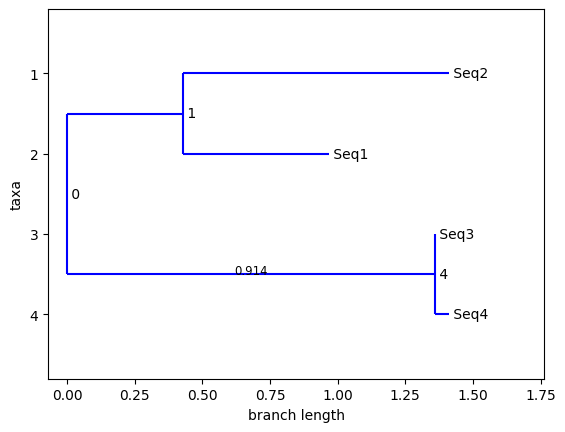

In [282]:
estimated_tree = create_tree(input_sequences)
(
    single_columns_probability, 
    paired_columns_probability,
    leaf_order,
) = get_columns_probability(
    estimated_tree,
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values
)

In [343]:
import math

In [367]:
b1 = 0
column = ["G", "U", "A", "C"]
column = ["G", "G", "G", "G"]
column = ["A", "A", "A", "A"]
for noc in ["A", "C", "G", "U"]:
    p = 1
    for index, leaf in enumerate(estimated_tree.get_terminals()):
        time = estimated_tree.distance(estimated_tree.root, leaf)
        ll = len(estimated_tree.get_path(leaf))
        
        mutation_probablities = get_mutation_probablities(single_rate_values, time / ll)
        p *= mutation_probablities[(noc, column[index])]
    # print(p)
    b1 += p * single_frequencies[noc]

print(b1)
# Print distances
# for leaf, distance in leaf_distances.items():
#     print(f"Leaf {leaf}: Distance from root = {distance:.4f}")

0.11256973454277852


In [368]:
b2 = 0
column = ["C", "U", "A", "C"]
# column = ["G", "G", "G", "G"]
for noc in ["A", "C", "G", "U"]:
    p = 1
    for index, leaf in enumerate(estimated_tree.get_terminals()):
        time = estimated_tree.distance(estimated_tree.root, leaf)
        ll = len(estimated_tree.get_path(leaf))
        
        mutation_probablities = get_mutation_probablities(single_rate_values, time / ll)
        p *= (math.pow(mutation_probablities[(noc, column[index])], ll) * ll)
    # print(p)
    b2 += p * single_frequencies[noc]

print(b2)

0.00016438277788386534


In [369]:
t1 = single_columns_probability[("G", "G", "G", "G")]
t1 = single_columns_probability[("A", "A", "A", "A")]
t2 = single_columns_probability[("C", "U", "A", "C")]

In [370]:
t1, t2

(np.float64(0.09691776881199074), np.float64(8.873345120356243e-05))

In [371]:
single_possible_values = ['A', 'C', 'G', 'U']
paired_possible_values = [c1 + c2 for c1 in single_possible_values for c2 in single_possible_values]

In [277]:
a = 0
column = ["GC", "GU","GA","GC"]
for noc in paired_possible_values:
    p = 1
    for index, leaf in enumerate(estimated_tree.get_terminals()):
        time = estimated_tree.distance(estimated_tree.root, leaf)
        ll = len(estimated_tree.get_path(leaf))
        mutation_probablities = get_mutation_probablities(paired_rate_values, time / ll  , paired_possible_values)
        p *= mutation_probablities[(noc, column[index])]
    # print(p)
    a += p * paired_frequencies[noc]

print(a)

3.009938931370133e-07


In [280]:
b1*b2

np.float64(1.4524919228983052e-07)

In [279]:
t2 * t1 

np.float64(7.209575568480774e-08)

In [278]:
paired_columns_probability[("GC", "GU","GA","GC")]

np.float64(3.566400061784556e-07)